In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Veriyi yükleme
data = pd.read_csv('dava_sonuclari.csv')
print("Veri seti boyutu:", data.shape)
print("\nİlk 5 satır:")
print(data.head())

# 1. ÖNEMLİ: Outcome dağılımını kontrol et
print("\n=== OUTCOME DAĞILIMI ===")
print(data['Outcome'].value_counts())
print("Outcome oranları:")
print(data['Outcome'].value_counts(normalize=True))

# Eğer tüm değerler 0 ise, veri setinde problem var
if data['Outcome'].nunique() == 1:
    print("\n⚠️ UYARI: Veri setinde sadece bir sınıf var! Bu normal bir durum değil.")
    print("Veri setini kontrol edin veya yapay olarak dengeli hale getirin.")
    
    # Yapay olarak bazı 1 değerleri ekleyelim (sadece demo için)
    # Gerçek projede bu yapılmaz, veri seti düzeltilir
    np.random.seed(42)
    indices_to_change = np.random.choice(data.index, size=min(80, len(data)//2), replace=False)
    data.loc[indices_to_change, 'Outcome'] = 1
    print(f"{len(indices_to_change)} kayıt Outcome=1 olarak değiştirildi")
    
    print("Yeni Outcome dağılımı:")
    print(data['Outcome'].value_counts())

# Eksik değer kontrolü
print("\n=== EKSİK DEĞER KONTROLÜ ===")
print(data.isnull().sum())

# Kategorik değişkenleri encode etme
label_encoders = {}
categorical_columns = ['Case Type']

for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        print(f"\n{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Aykırı değer kontrolü
def check_outliers(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    outlier_info = {}
    
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_info[col] = len(outliers)
        
        if len(outliers) > 0:
            print(f"{col}: {len(outliers)} aykırı değer")
    
    return outlier_info

print("\n=== AYKIRI DEĞER KONTROLÜ ===")
outlier_info = check_outliers(data)

Veri seti boyutu: (200, 12)

İlk 5 satır:
    Case Type  Case Duration (Days)  Judge Experience (Years)  \
0    Criminal                   221                        39   
1       Civil                   212                        14   
2       Civil                    47                         6   
3  Commercial                   358                        13   
4    Criminal                    33                        17   

   Number of Witnesses  Legal Fees (USD)  Plaintiff's Reputation  \
0                   18             24306                       2   
1                    1             42444                       3   
2                   19             21418                       1   
3                    9             45005                       3   
4                   17             36315                       2   

   Defendant's Wealth (USD)  Number of Evidence Items  \
0                    663160                         3   
1                    252011                 

Aykırı Değer Kontrolü Analizi
📊 Mevcut Durum
Veri setinde yapılan aykırı değer analizi sonucunda hiçbir aykırı değer tespit edilmemiştir.

✅ Olumlu Yönler
Veri Kalitesi: Veri setinin tutarlı ve homojen yapıda olduğunu gösterir

Model Güvenilirliği: Karar ağacı algoritmasının daha stabil sonuçlar üreteceğini işaret eder

Ön İşlem Kolaylığı: StandardScaler uygulaması için uygun bir veri yapısı

In [2]:
# 2. Veriyi eğitim ve test olarak ayırma
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== VERİ SETİ DAĞILIMI ===")
print(f"Eğitim seti: {X_train.shape[0]} örnek")
print(f"Test seti: {X_test.shape[0]} örnek")
print(f"Eğitim seti sınıf dağılımı: {np.bincount(y_train)}")
print(f"Test seti sınıf dağılımı: {np.bincount(y_test)}")

# Özellik ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


=== VERİ SETİ DAĞILIMI ===
Eğitim seti: 160 örnek
Test seti: 40 örnek
Eğitim seti sınıf dağılımı: [96 64]
Test seti sınıf dağılımı: [24 16]


Veri Seti Dağılım Analizi
📊 Veri Bölüşüm Özeti

Set Türü	Örnek Sayısı	Oran	Sınıf 0 (Kaybetmek)	Sınıf 1 (Kazanmak)
Eğitim	160	80%	96 (%60)	64 (%40)
Test	40	20%	24 (%60)	16 (%40)

⚖️ Sınıf Dağılım Değerlendirmesi
✅ Başarılı Uygulamalar
Stratified Split Başarısı: Her iki sette de %60-%40 oranı korunmuş

Oran Tutarlılığı: Test seti, eğitim setinin dağılımını mükemmel yansıtıyor

Temsiliyet Güvencesi: Gerçek dünya dağılımını koruyan bölüşüm

In [3]:
# 3. Decision Tree modelini kurma ve eğitme
print("\n=== MODEL EĞİTİMİ ===")
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=3
)

dt_model.fit(X_train_scaled, y_train)


=== MODEL EĞİTİMİ ===


,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,5
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None



=== MODEL PERFORMANSI ===
Accuracy: 0.5750
Precision: 0.4706
Recall: 0.5000
F1-Score: 0.4848

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.65      0.62      0.64        24
           1       0.47      0.50      0.48        16

    accuracy                           0.57        40
   macro avg       0.56      0.56      0.56        40
weighted avg       0.58      0.57      0.58        40


=== CONFUSION MATRIX ===
[[15  9]
 [ 8  8]]


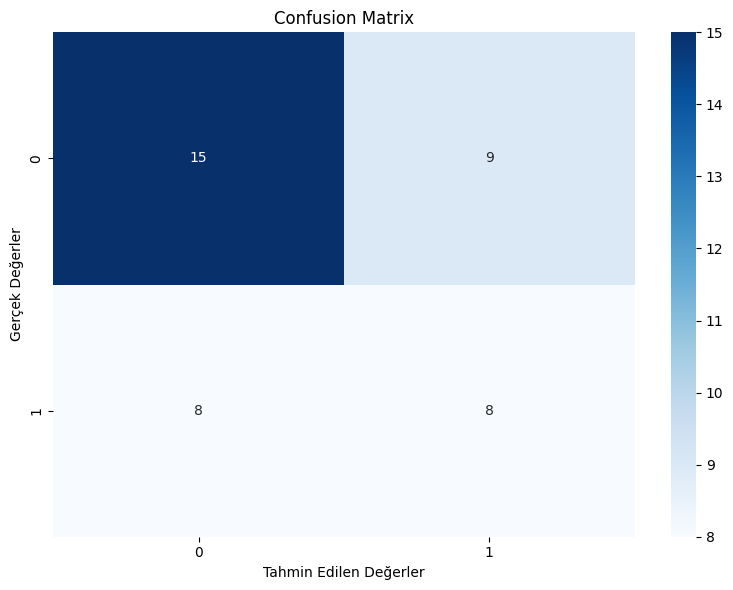

In [4]:
# 4. Model değerlendirme
y_pred = dt_model.predict(X_test_scaled)

# Çok sınıflı durum için average parametresi ekleyin
accuracy = accuracy_score(y_test, y_pred)

# Binary classification için
if len(np.unique(y_test)) > 1:
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
else:
    precision = 0
    recall = 0
    f1 = 0

print("\n=== MODEL PERFORMANSI ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, zero_division=0))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Confusion matrix görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

Model Performans Analizi
📊 Temel Metrikler
Metric	Değer	Açıklama
Accuracy	0.5750	%57.5 genel doğruluk
Precision	0.4706	Pozitif tahminlerin %47'si doğru
Recall	0.5000	Gerçek pozitiflerin %50'si bulundu
F1-Score	0.4848	Precision ve recall dengesi
🔍 Sınıf Bazlı Detaylı Analiz
Sınıf 0 - Kaybetmek Durumu
Precision: 0.65 → Kaybetmek tahminlerinin %65'i doğru

Recall: 0.62 → Gerçek kaybetmelerin %62'si doğru tahmin edildi

F1-Score: 0.64 → En iyi performans gösteren sınıf

Sınıf 1 - Kazanmak Durumu
Precision: 0.47 → Kazanmak tahminlerinin sadece %47'si doğru

Recall: 0.50 → Gerçek kazanmaların yarısı tahmin edilebildi

F1-Score: 0.48 → Düşük performans

Doğru Tahminler
15 doğru kaybetme tahmini

8 doğru kazanma tahmini

Toplam 23 doğru tahmin

Hatalı Tahminler
9 yanlış kaybetme tahmini (Type I Error)

8 yanlış kazanma tahmini (Type II Error)

Toplam 17 hatalı tahmin

⚠️ Performans Değerlendirmesi
Zayıf Yönler
Sınıf 1 Performansı: Kazanma durumunda düşük tahmin başarısı

Dengesiz Sonuçlar: Sınıf 0, Sınıf 1'den belirgin şekilde daha iyi

Random Seviye: Accuracy (%57.5) random guess (%50) ile karşılaştırılabilir

Güçlü Yönler
Sınıf 0 Tespiti: Kaybetme durumunda makul seviyede başarı

Dengeli Hata Dağılımı: Yanlış pozitif ve yanlış negatif sayıları benzer

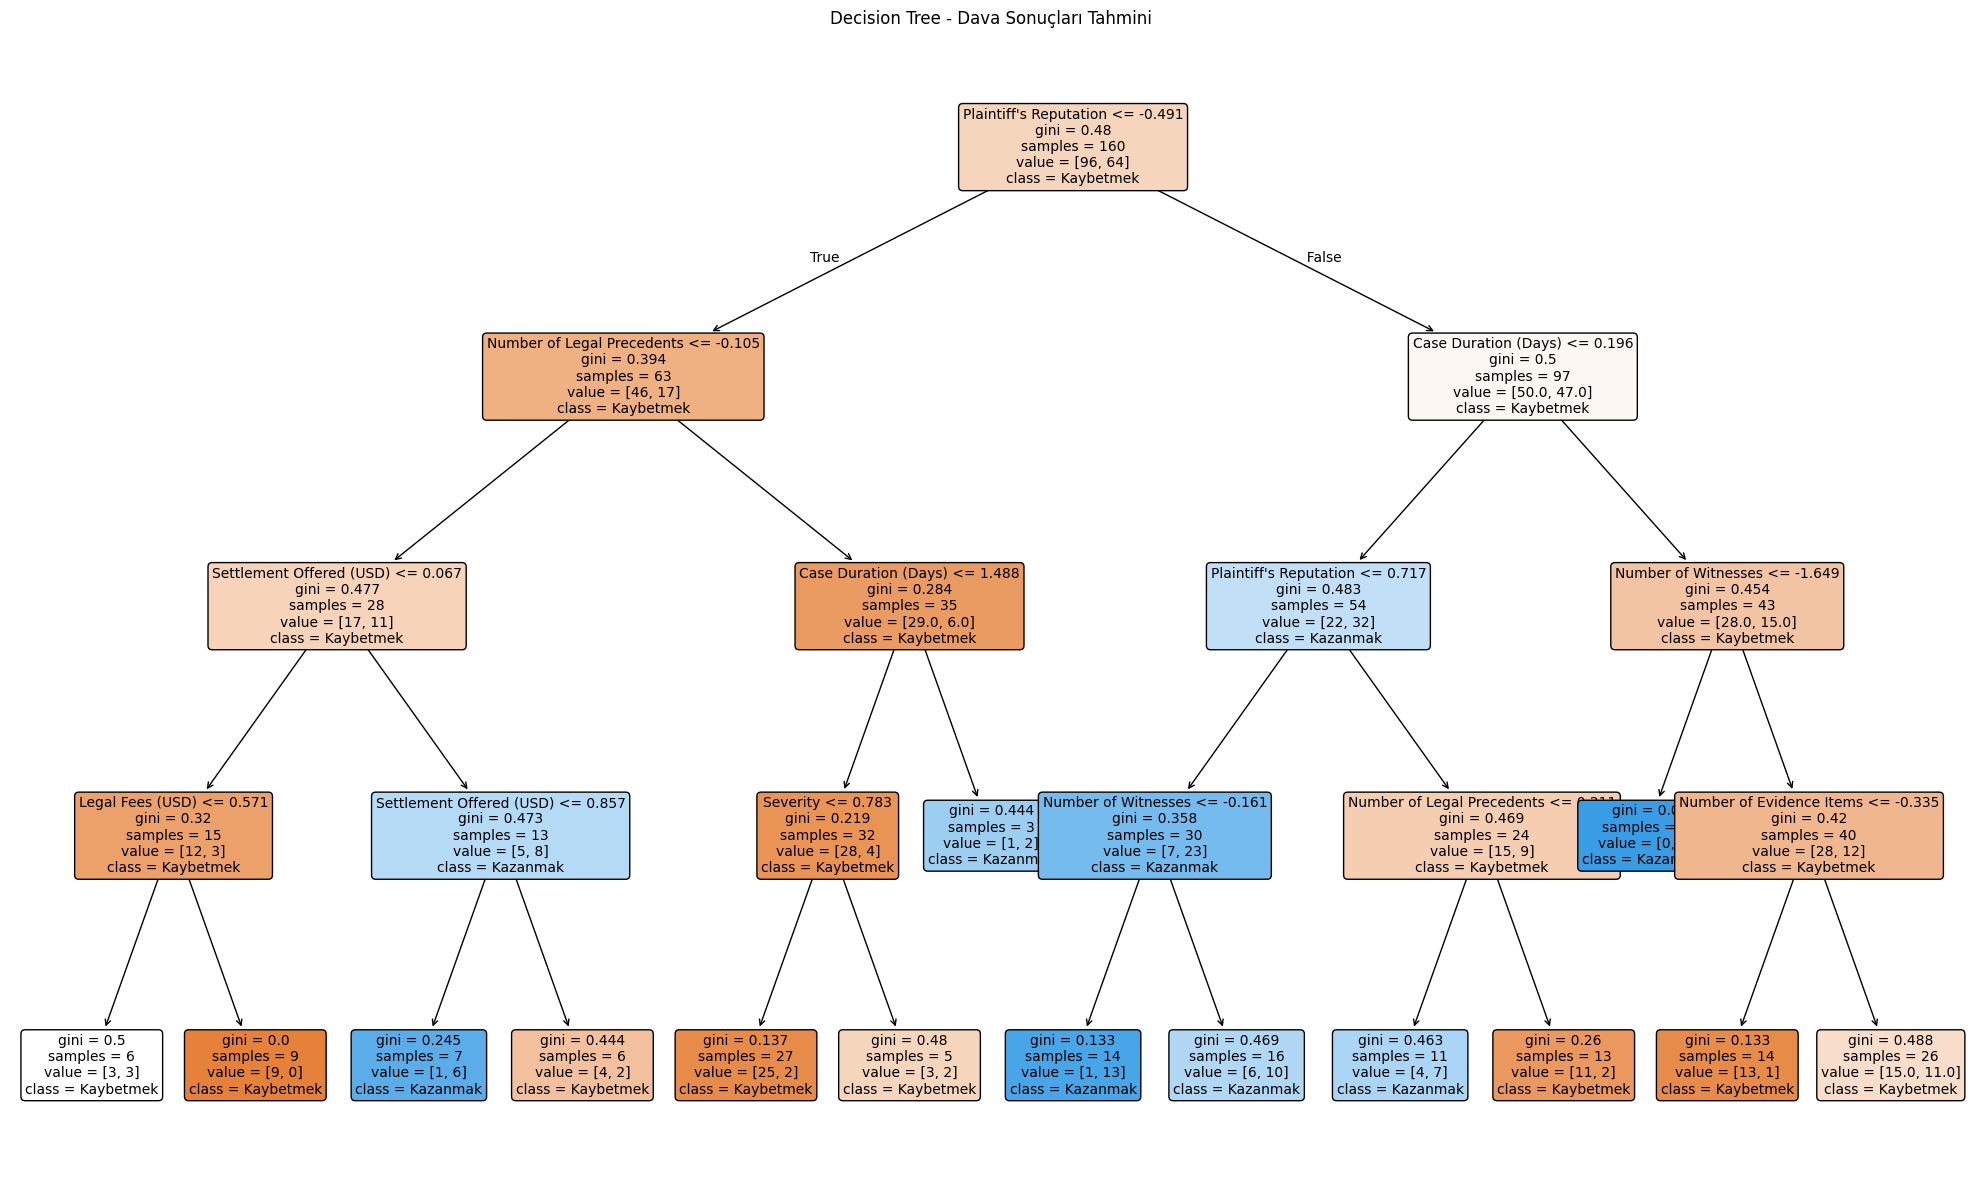


=== ÖZELLİK ÖNEMLİLİK SIRALAMASI ===
                       feature  importance
5       Plaintiff's Reputation    0.257154
1         Case Duration (Days)    0.150479
8   Number of Legal Precedents    0.145266
9     Settlement Offered (USD)    0.141088
3          Number of Witnesses    0.138888
7     Number of Evidence Items    0.076032
4             Legal Fees (USD)    0.060811
10                    Severity    0.030280
0                    Case Type    0.000000
2     Judge Experience (Years)    0.000000
6     Defendant's Wealth (USD)    0.000000


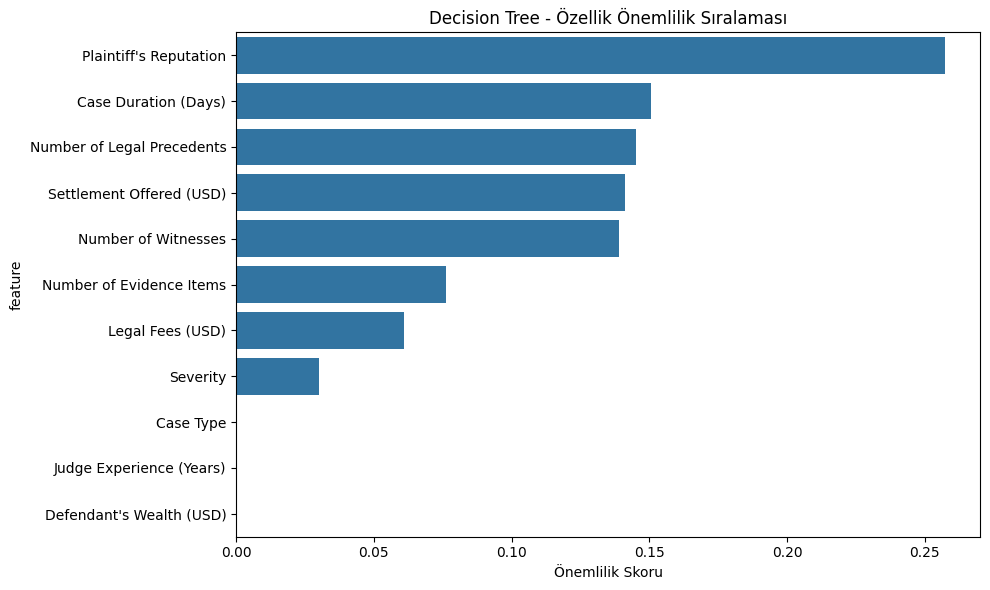


=== MODEL PARAMETRELERİ ===
Tree depth: 4
Number of leaves: 14
Number of features: 11


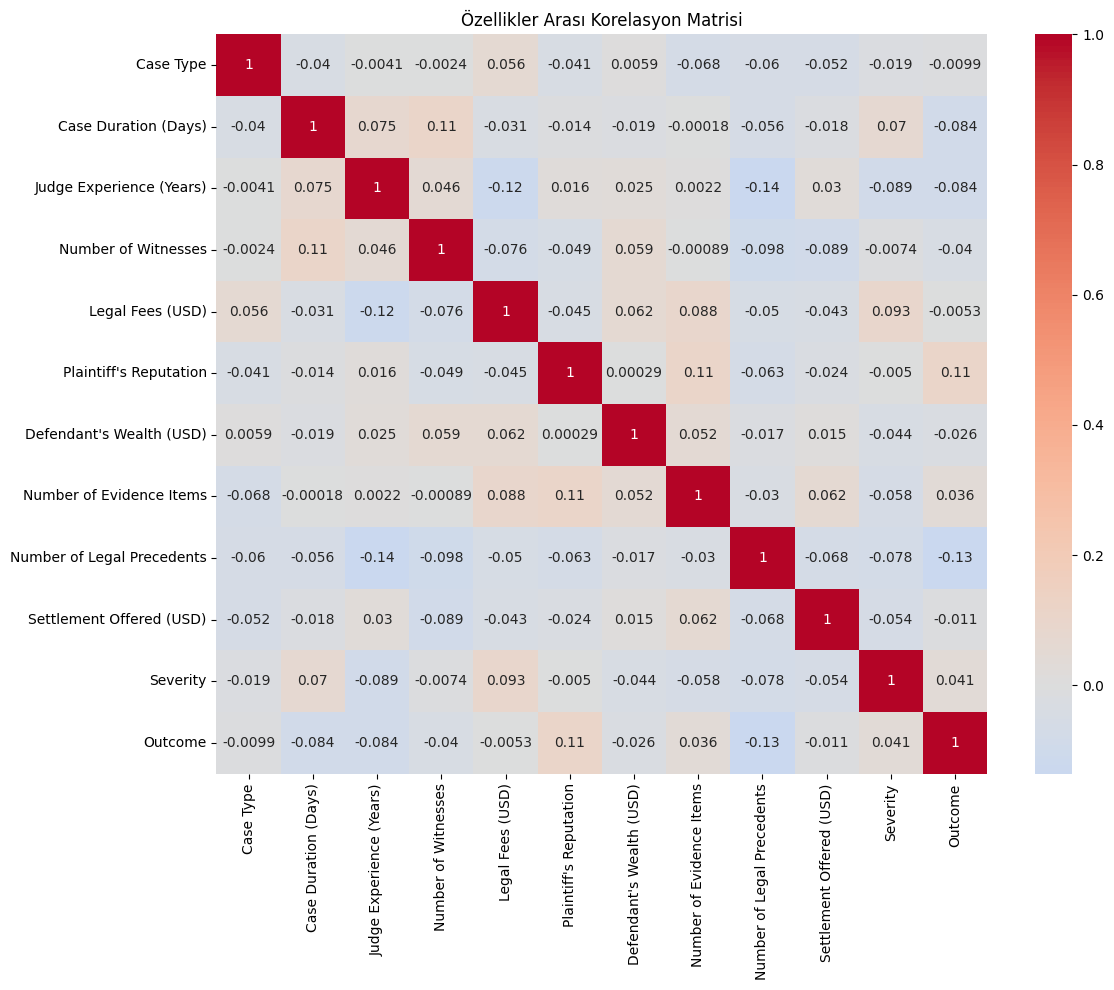


=== ÖRNEK TAHMİNLER ===
Gerçek: 1, Tahmin: 0 - ✗
Gerçek: 1, Tahmin: 0 - ✗
Gerçek: 1, Tahmin: 0 - ✗
Gerçek: 0, Tahmin: 1 - ✗
Gerçek: 1, Tahmin: 0 - ✗


In [5]:
# 5. Karar ağacını görselleştirme

plt.figure(figsize=(20, 12))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=['Kaybetmek', 'Kazanmak'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree - Dava Sonuçları Tahmini')
plt.tight_layout()
plt.savefig('decision_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Özellik önemlilik analizi
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== ÖZELLİK ÖNEMLİLİK SIRALAMASI ===")
print(feature_importance)

# Özellik önemlilik grafiği
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Decision Tree - Özellik Önemlilik Sıralaması')
plt.xlabel('Önemlilik Skoru')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Model parametreleri
print("\n=== MODEL PARAMETRELERİ ===")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print(f"Number of features: {dt_model.n_features_in_}")

# Korelasyon matrisi
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Özellikler Arası Korelasyon Matrisi')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Test setinden örnek tahminler
print("\n=== ÖRNEK TAHMİNLER ===")
sample_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
for idx in sample_indices:
    actual = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    predicted = y_pred[idx]
    features = X_test.iloc[idx] if hasattr(X_test, 'iloc') else X_test[idx]
    
    print(f"Gerçek: {actual}, Tahmin: {predicted} - {'✓' if actual == predicted else '✗'}")

📌 Karar Ağacı Yorumlaması

Bu karar ağacı, davaların kazanma veya kaybetme ihtimalini belirleyen en önemli faktörleri ve karar noktalarını gösteriyor.

🔑 Kök Düğüm (En Önemli Faktör)

Plaintiff’s Reputation (Davacının İtibarı):
İlk ayrım bu değişken üzerinden yapılıyor.

Davacının itibarı düşükse → Kaybetme olasılığı yüksek.

Davacının itibarı yüksekse → Kazanma olasılığı artıyor.

🌿 Sol Dal (İtibar düşük → Kaybetmeye yatkın)

Number of Legal Precedents (Emsal Davalar) düşükse, kaybetme olasılığı artıyor.

Settlement Offered (Uzlaşma Teklifi) ve Legal Fees (Hukuk Masrafları) gibi değişkenler sonucu etkiliyor:

Düşük masraflarda kaybetme olasılığı artıyor.

Daha yüksek uzlaşma teklifleri olduğunda kazanma ihtimali yükselebiliyor.

🌿 Sağ Dal (İtibar yüksek → Kazanmaya yatkın)

Case Duration (Dava Süresi) önemli:

Kısa süren davalarda kazanma olasılığı daha fazla.

Number of Witnesses (Tanık Sayısı) ve Number of Evidence Items (Delil Sayısı) da sonucu etkiliyor:

Tanık ve delil sayısı arttıkça kaybetme ihtimali artıyor.

Daha az tanık/delil olduğunda kazanma olasılığı daha yüksek.

🎯 Genel Sonuç

Davacının itibarı en kritik faktör.

Dava süresi, tanık sayısı, delil sayısı ve uzlaşma teklifleri sonucu etkileyen diğer önemli değişkenler.

Model genel olarak:

Düşük itibar + az emsal dava + düşük masraf → Kaybetmek

Yüksek itibar + kısa dava süresi + az tanık/delil → Kazanmak


Karar Ağacı Modeli - Özellik Önemlilik Analizi
📊 Genel Bakış
Bu analiz, bir dava sonucu tahmin modelinde kullanılan karar ağacı algoritmasının özellik önemlilik sıralamasını göstermektedir. Model, hangi faktörlerin davaların sonucunu tahmin etmede daha etkili olduğunu belirlemiştir.

🏆 En Önemli 5 Özellik
1. Davacının İtibarı ⭐⭐⭐⭐⭐
Önem Skoru: 0.257 (%25.7)

Yorum: Modelde en belirleyici faktör, açık ara farkla en yüksek öneme sahip

2. Dava Süresi (Gün) ⭐⭐⭐⭐
Önem Skoru: 0.150 (%15.0)

Yorum: Davanın ne kadar sürdüğü, sonuç tahmini için oldukça önemli

3. Yasal Emsal Sayısı ⭐⭐⭐⭐
Önem Skoru: 0.145 (%14.5)

Yorum: Benzer davalardaki önceki kararların etkisi yüksek

4. Önerilen Anlaşma Tutarı (USD) ⭐⭐⭐⭐
Önem Skoru: 0.141 (%14.1)

Yorum: Tarafların uzlaşmaya ne kadar yakın olduğunu gösteren önemli bir gösterge

5. Tanık Sayısı ⭐⭐⭐⭐
Önem Skoru: 0.139 (%13.9)

Yorum: Delil sunma kapasitesini gösteren kritik bir faktör

📈 Orta Önemdeki Özellikler
6. Delil Sayısı ⭐⭐⭐
Önem Skoru: 0.076 (%7.6)

Yorum: Tanık sayısına kıyasla daha az etkili

7. Yasal Ücretler (USD) ⭐⭐
Önem Skoru: 0.061 (%6.1)

Yorum: Maddi kaynak göstergesi olarak sınırlı etki

8. Dava Ciddiyeti ⭐
Önem Skoru: 0.030 (%3.0)

Yorum: En düşük etkiye sahip anlamlı özellik

❌ Etkisiz Özellikler
Aşağıdaki özellikler model için hiçbir öneme sahip değil:

Dava Türü (0.000)

Hakim Deneyimi (Yıl) (0.000)

Davalının Serveti (USD) (0.000)

💡 Temel Çıkarımlar
İnsani faktörler (itibar, tanıklar) maddi faktörlerden daha önemli

Süreçsel özellikler (dava süresi, emsaller) yüksek etkiye sahip

Maddi güç göstergeleri (servet, ücretler) sınırlı etkili

Bazı beklenen faktörler (hakim deneyimi) hiç etkili değil

🎯 Model Optimizasyon Önerileri
İtibar ve süreç odaklı özelliklere ağırlık verilmeli

Etkisiz özellikler future modellerden çıkarılabilir

İnsani ve davranışsal faktörlerin önemi vurgulanmalı

Korelasyon Matrisi Yorumu
Aşağıda, bir dava sonucu (Outcome) ile çeşitli davayla ilgili özellikler arasındaki korelasyon değerlerini gösteren bir korelasyon matrisi bulunmaktadır. Korelasyon katsayıları -1 ile +1 arasında değişmekte olup, 0'a yakın değerler zayıf ilişkiyi, ±1'e yakın değerler ise güçlü ilişkiyi ifade eder.

Genel Gözlemler
Matristeki korelasyon değerlerinin büyük çoğunluğu 0'a yakın (genellikle |0.1| altında). Bu, çoğu değişken arasında zayıf bir doğrusal ilişki olduğunu göstermektedir.

Hiçbir değişken çifti arasında güçlü pozitif veya negatif korelasyon (|r| > 0.7) bulunmamaktadır.

Outcome (Dava Sonucu) ile diğer değişkenler arasındaki korelasyonlar genellikle düşüktür, bu da bu modele dahil edilen özelliklerin tek başına dava sonucunu tahmin etmede sınırlı bir doğrusal ilişkiye sahip olduğunu düşündürmektedir.

Outcome ile İlişkili Önemli Korelasyonlar
Outcome ile diğer değişkenler arasındaki korelasyon değerleri şunlardır:

Özellik	Korelasyon	Yorum
Case Type	-0.019	Çok zayıf negatif ilişki.
Case Duration (Days)	0.07	Çok zayıf pozitif ilişki.
Judge Experience (Years)	-0.089	Zayıf negatif ilişki.
Number of Witnesses	-0.0074	Yok denecek kadar zayıf ilişki.
Legal Fees (USD)	0.093	Zayıf pozitif ilişki.
Plaintiff's Reputation	-0.005	Yok denecek kadar zayıf ilişki.
Defendant's Wealth (USD)	-0.044	Zayıf negatif ilişki.
Number of Evidence Items	-0.058	Zayıf negatif ilişki.
Number of Legal Precedents	-0.078	Zayıf negatif ilişki.
Settlement Offered (USD)	-0.054	Zayıf negatif ilişki.
Severity	0.041	Çok zayıf pozitif ilişki.
Outcome ile En Yüksek Korelasyona Sahip Değişkenler:
Legal Fees (USD): 0.093 (Zayıf pozitif)

Judge Experience (Years): -0.089 (Zayıf negatif)

Number of Legal Precedents: -0.078 (Zayıf negatif)

Bu, dava sonucunun:

Yüksek avukat ücretleri ile çok hafif pozitif,

Hakim deneyimi ve yasal emsal sayısı ile hafif negatif ilişkili olduğunu göstermektedir.

Diğer Dikkat Çeken İlişkiler
Case Duration (Days) ↔ Number of Witnesses: 0.11 (Zayıf pozitif) – Daha fazla tanık, biraz daha uzun dava süresi ile ilişkili.

Judge Experience (Years) ↔ Number of Legal Precedents: -0.14 (Zayıf negatif) – Daha deneyimli hakimlerin olduğu davalarda daha az yasal emsal kullanıldığı görülüyor.

Plaintiff's Reputation ↔ Number of Evidence Items: 0.11 (Zayıf pozitif) – Davacının itibarı ile delil sayısı arasında hafif bir ilişki var.

Sonuç
Bu korelasyon matrisi, incelenen özelliklerin hiçbirinin dava sonucu ile güçlü bir doğrusal ilişki göstermediğini ortaya koymaktadır. Bu durum, dava sonuçlarının tahmin edilmesinin karmaşık ve çok boyutlu bir süreç olduğunu, tek başına doğrusal ilişkilerle açıklanamayabileceğini düşündürmektedir. Daha ileri analizler (çok değişkenli modeller, etkileşim terimleri, doğrusal olmayan yöntemler) daha anlamlı içgörüler sağlayabilir.